In [8]:
import random
import matplotlib.pyplot as plt
from collections import deque

# --- Параметры задачи ---
INITIAL_STATE = (10, 50, 20, 80, 40)
NUM_GLASSES = len(INITIAL_STATE)
TOTAL_VOLUME = sum(INITIAL_STATE)
TARGET_VOLUME = TOTAL_VOLUME // NUM_GLASSES
GOAL_STATE = tuple([TARGET_VOLUME] * NUM_GLASSES)

# --- Гиперпараметры Q-обучения ---
LEARNING_RATE = 0.1      # Альфа
DISCOUNT_FACTOR = 0.95   # Гамма
EPSILON = 1.0            # Начальный эпсилон
EPSILON_DECAY = 0.999    # Коэффициент уменьшения
MIN_EPSILON = 0.01       # Минимальный эпсилон
EPISODES = 5000          # Количество эпизодов

print(f"Начальное состояние: {INITIAL_STATE}")
print(f"Целевое состояние: {GOAL_STATE}")

Начальное состояние: (10, 50, 20, 80, 40)
Целевое состояние: (40, 40, 40, 40, 40)


In [9]:
class CompoteEnv:
    """
    Среда, где действие - это выбор стакана для оптимального розлива.
    """
    def __init__(self, initial_state, target_volume):
        self.initial_state = tuple(initial_state)
        self.target_volume = target_volume
        self.goal_state = tuple([target_volume] * len(initial_state))
        self.num_glasses = len(initial_state)

    def reset(self):
        """Сбрасывает среду в начальное состояние."""
        self.state = self.initial_state
        return self.state

    def step(self, source_glass_idx):
        """
        Выполняет комплексное действие: поднимает стакан source_glass_idx
        и оптимально разливает излишки.
        """
        current_state_list = list(self.state)
        
        # Проверка, есть ли вообще смысл поднимать этот стакан
        if current_state_list[source_glass_idx] <= self.target_volume:
            # Бесполезное действие: наказываем и не меняем состояние
            return self.state, -10, False

        # --- Логика оптимального розлива ---
        next_state_list = list(self.state)
        
        # Определяем излишек, который можно разлить
        pourable_amount = next_state_list[source_glass_idx] - self.target_volume
        # В исходном стакане оставляем ровно целевой объем
        next_state_list[source_glass_idx] = self.target_volume
        
        # Распределяем излишек по другим стаканам, которым не хватает
        for j in range(self.num_glasses):
            if source_glass_idx == j or pourable_amount <= 0:
                continue
            
            if next_state_list[j] < self.target_volume:
                needed = self.target_volume - next_state_list[j]
                transfer = min(pourable_amount, needed)
                
                next_state_list[j] += transfer
                pourable_amount -= transfer
        
        self.state = tuple(next_state_list)
        
        # --- Определение награды ---
        done = (self.state == self.goal_state)
        if done:
            reward = 100  # Большая награда за достижение цели
        else:
            reward = -1   # Штраф за каждое поднятие
            
        return self.state, reward, done

In [10]:
class QLearningAgent:
    """
    Агент, использующий Q-обучение. Его логика универсальна.
    """
    def __init__(self, actions, learning_rate, discount_factor, epsilon):
        self.actions = actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            q_values = [self.get_q_value(state, a) for a in self.actions]
            max_q = max(q_values)
            best_actions = [i for i, q in enumerate(q_values) if q == max_q]
            chosen_action_index = random.choice(best_actions)
            return self.actions[chosen_action_index]

    def update_q_value(self, state, action, reward, next_state):
        old_q = self.get_q_value(state, action)
        future_q_values = [self.get_q_value(next_state, a) for a in self.actions]
        max_future_q = max(future_q_values) if future_q_values else 0
        
        new_q = old_q + self.lr * (reward + self.gamma * max_future_q - old_q)
        self.q_table[(state, action)] = new_q

In [11]:
# 1. Создаем среду с новой логикой
env = CompoteEnv(INITIAL_STATE, TARGET_VOLUME)

# 2. Определяем возможное пространство действий
# Действие - это просто индекс стакана, который нужно поднять (от 0 до 4)
possible_actions = list(range(NUM_GLASSES))

# 3. Создаем агента
agent = QLearningAgent(
    actions=possible_actions,
    learning_rate=LEARNING_RATE,
    discount_factor=DISCOUNT_FACTOR,
    epsilon=EPSILON
)

print(f"Пространство действий агента: {possible_actions}")

Пространство действий агента: [0, 1, 2, 3, 4]


In [12]:
rewards_per_episode = []
moving_avg_rewards = deque(maxlen=100)
moving_averages = []

print("--- Начало обучения (с новой логикой действий) ---")
for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0
    done = False
    
    # Ограничим шаги, чтобы избежать слишком длинных бесполезных эпизодов
    for step in range(10): 
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update_q_value(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
        
        if done:
            break
            
    if agent.epsilon > MIN_EPSILON:
        agent.epsilon *= EPSILON_DECAY

    rewards_per_episode.append(total_reward)
    moving_avg_rewards.append(total_reward)
    moving_averages.append(sum(moving_avg_rewards) / len(moving_avg_rewards))
    
    if (episode + 1) % 500 == 0:
        print(f"Эпизод {episode + 1}/{EPISODES} | Средняя награда (100 эп.): {moving_averages[-1]:.2f} | Epsilon: {agent.epsilon:.3f}")

print("--- Обучение завершено ---")

--- Начало обучения (с новой логикой действий) ---
Эпизод 500/5000 | Средняя награда (100 эп.): 83.40 | Epsilon: 0.606
Эпизод 1000/5000 | Средняя награда (100 эп.): 92.00 | Epsilon: 0.368
Эпизод 1500/5000 | Средняя награда (100 эп.): 95.80 | Epsilon: 0.223
Эпизод 2000/5000 | Средняя награда (100 эп.): 97.00 | Epsilon: 0.135
Эпизод 2500/5000 | Средняя награда (100 эп.): 97.90 | Epsilon: 0.082
Эпизод 3000/5000 | Средняя награда (100 эп.): 97.90 | Epsilon: 0.050
Эпизод 3500/5000 | Средняя награда (100 эп.): 98.70 | Epsilon: 0.030
Эпизод 4000/5000 | Средняя награда (100 эп.): 98.60 | Epsilon: 0.018
Эпизод 4500/5000 | Средняя награда (100 эп.): 98.80 | Epsilon: 0.011
Эпизод 5000/5000 | Средняя награда (100 эп.): 98.80 | Epsilon: 0.010
--- Обучение завершено ---


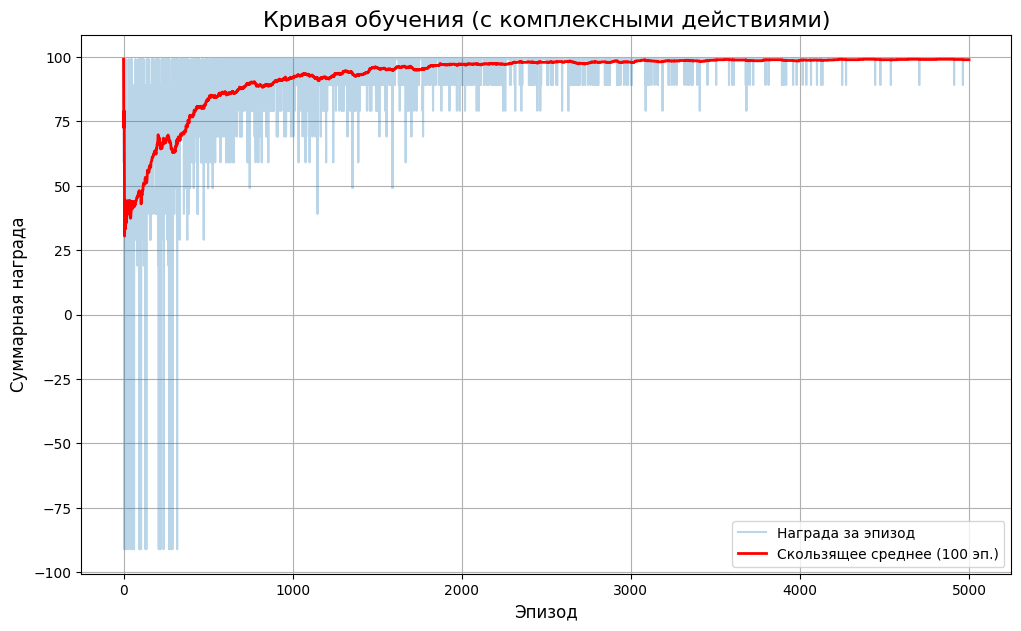

In [13]:
plt.figure(figsize=(12, 7))
plt.plot(rewards_per_episode, label='Награда за эпизод', alpha=0.3)
plt.plot(moving_averages, label='Скользящее среднее (100 эп.)', color='red', linewidth=2)
plt.title('Кривая обучения (с комплексными действиями)', fontsize=16)
plt.xlabel('Эпизод', fontsize=12)
plt.ylabel('Суммарная награда', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [14]:
state = env.reset()
print(f"Начальное состояние: {state}")

path = [state]
agent.epsilon = 0 # Отключаем случайность для демонстрации
done = False

for i in range(10): # Ограничение шагов
    action = agent.choose_action(state)
    
    prev_state_for_print = state
    state, _, done = env.step(action)
    
    if state == prev_state_for_print:
        print(f"\nАгент попытался совершить бесполезное действие (поднять стакан {action + 1}). Поиск остановлен.")
        break

    path.append(state)
    
    print(f"\nШаг {i+1}: Агент выбрал действие {action} (поднять стакан {action + 1})")
    print(f"Результат: {state}")
    
    if done:
        print("\nЦель достигнута!")
        break

Начальное состояние: (10, 50, 20, 80, 40)

Шаг 1: Агент выбрал действие 1 (поднять стакан 2)
Результат: (20, 40, 20, 80, 40)

Шаг 2: Агент выбрал действие 3 (поднять стакан 4)
Результат: (40, 40, 40, 40, 40)

Цель достигнута!
